# Seleção da Database
## Database: 
Brazilian E-Commerce Public Database by Olist
https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv

### Descrição: 
A database foi provida pela Olist, uma empresa de marketplace situada no Brasil. A Olist conecta pequenos negócios por todo o Brasil de uma forma simples. Vendedores conseguem vender seus produtos diretamente pela Olist Store, as entregas são feitas por meio de parceiros.

### Problema de Negócio:
Quais são os principais fatores que alavancam o número de vendas? Quais os fatores que impactam na avaliação do cliente?

### Perguntas:
- 1. Como as vendas foram afetadas entre 2016 e 2018?

- 2. Existe diferença significativa de venda para cada um dos seguintes fatores:
    - Mês
    - Dia da Semana
    - Método de Pagamento
    - Região   
   
- 3. Quais produtos e categoria possuem maiores vendas?
   
- 4. As notas de review do produto possuem impacto no número de vendas?
    - Realizar plot de nuvem de palavras

- 5. A localização impacta no tempo de entrega?
    - Heatmap por localização (Mapa)

- 6. O tempo de entrega impacta no review do produto?

- 7. Quais categorias são mais consumidas por região?
    - Diferentes regiões possuem maior adesão por diferentes tipos de produto?

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import string
import nltk
import os
import folium

from warnings import simplefilter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap

In [276]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher e João Hutner" --iversions

Author: Herikc Brecher e João Hutner

pandas    : 1.2.4
matplotlib: 3.3.4
nltk      : 3.6.1
seaborn   : 0.11.1
re        : 2.2.1
numpy     : 1.19.5
folium    : 0.12.1



In [3]:
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_theme()

In [4]:
seed_ = 194
np.random.seed(seed_)

# 1. Carregamento dos Dados

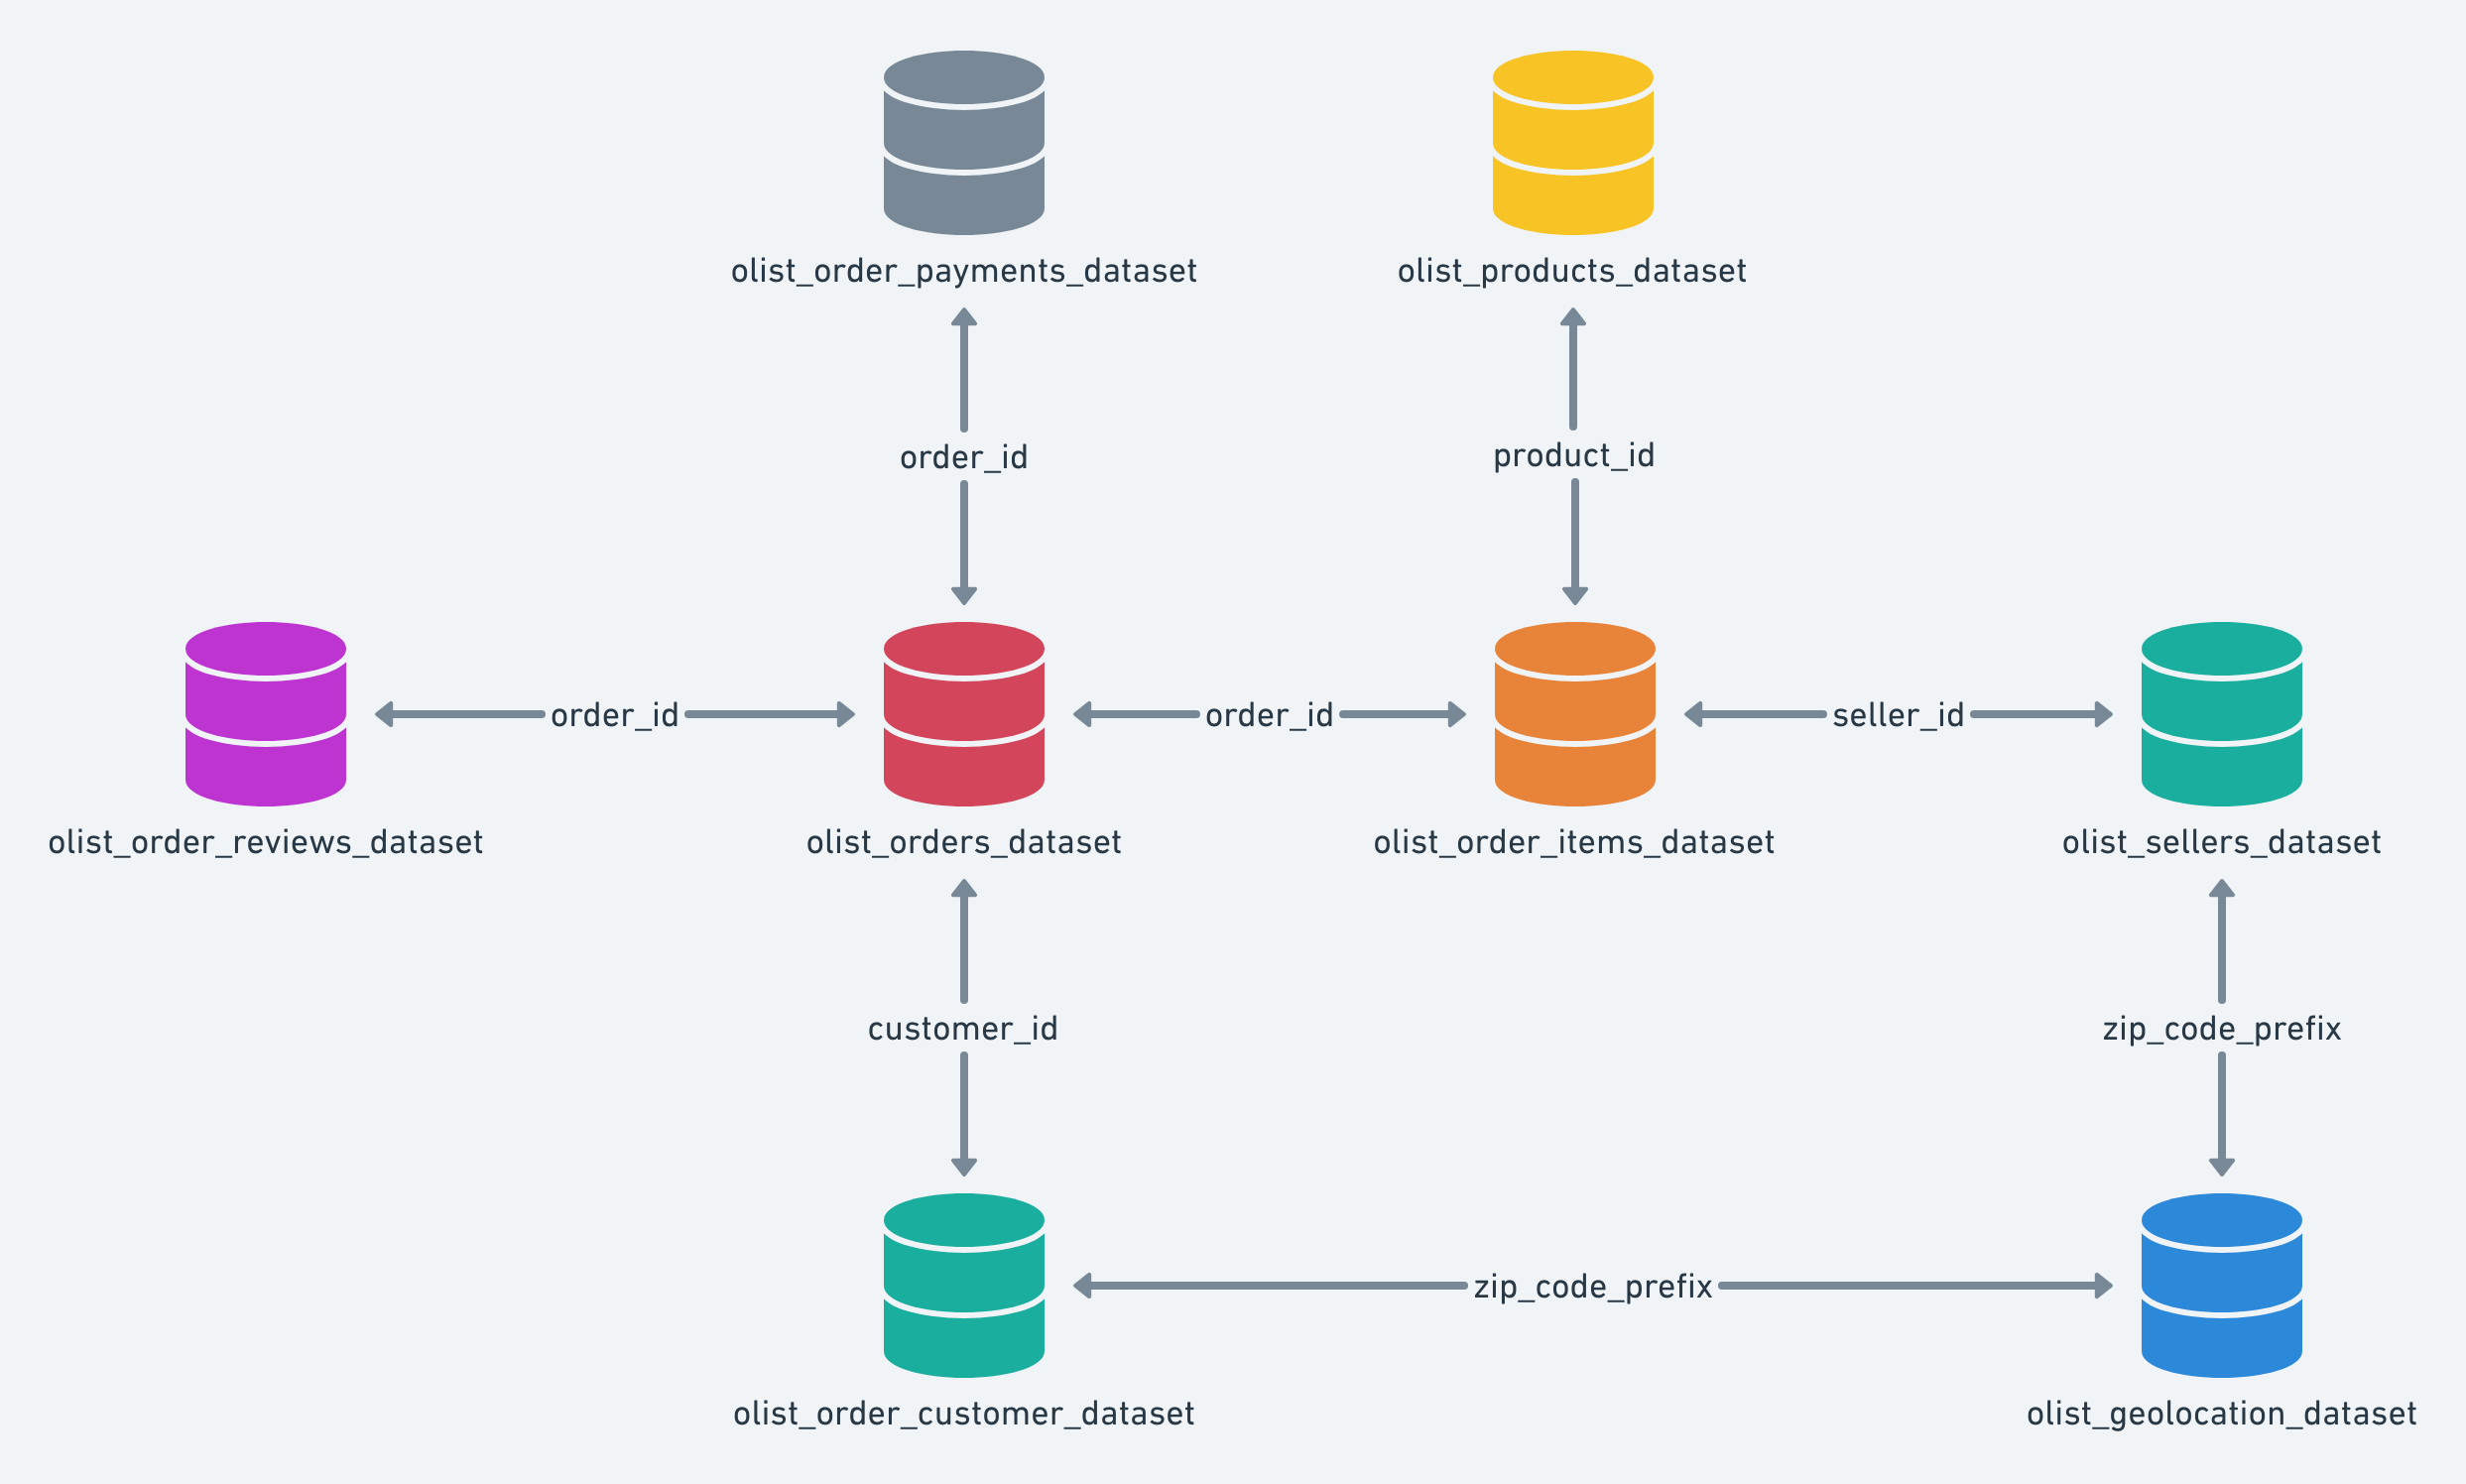

In [5]:
# Carregamento de todos datasets
dtCustomers = pd.read_csv('../data/olist_customers_dataset.csv', encoding = 'utf8')
dtGeolocation = pd.read_csv('../data/olist_geolocation_dataset.csv', encoding = 'utf8')
dtOrderItems = pd.read_csv('../data/olist_order_items_dataset.csv', encoding = 'utf8')
dtOrderPayments = pd.read_csv('../data/olist_order_payments_dataset.csv', encoding = 'utf8')
dtOrderReviews = pd.read_csv('../data/olist_order_reviews_dataset.csv', encoding = 'utf8')
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')
dtProducts = pd.read_csv('../data/olist_products_dataset.csv', encoding = 'utf8')
dtSellers = pd.read_csv('../data/olist_sellers_dataset.csv', encoding = 'utf8')

# 2. Analise Exploratória

# 2.1 Como as vendas foram afetadas entre 2016 e 2018? 

Para isso iremos fazer um grafico de analise temporal ao longo dos pedidos aprovados.

In [6]:
# Dataset de pedidos
dtOrders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
dtOrders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [8]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAjustado = dtOrders.copy()

In [9]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAjustado[col] = pd.to_datetime(dtOrdersAjustado[col], format = '%Y-%m-%d %H:%M:%S')

In [10]:
dtOrdersAjustado.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [11]:
dtOrdersAjustado.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [12]:
# Verificando tipos unicos
print(dtOrdersAjustado.nunique())

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64


In [13]:
# Verificando columas com null
print(dtOrdersAjustado.isna().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


Verificamos que possuem valores NA no dataset. Abaixo iremos verificar que possuem apenas 2980 observações como NA. Por essas representaem um valor pequeno do dataset iremos removelas. 

In [14]:
# Verificando valores NA
dtOrdersAjustado[dtOrdersAjustado.isna().any(axis = 1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [15]:
# Dropando valores NA
dtOrdersAjustado = dtOrdersAjustado.dropna()

In [16]:
# Verificando se possuem valores duplicados
print(sum(dtOrdersAjustado.duplicated()))

0


In [17]:
dtOrdersAjustado.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [18]:
dtOrdersMesAno = dtOrdersAjustado.copy()

# Mantendo somente Ano e Mes
for col in dateColumns:
    dtOrdersMesAno[col] = pd.to_datetime(dtOrdersMesAno[col], format = '%Y-%m-%d %H:%M:%S').dt.to_period('M')

In [19]:
dtOrdersMesAno.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10,2017-10,2017-10,2017-10,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07,2018-07,2018-07,2018-08,2018-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08,2018-08,2018-08,2018-08,2018-09
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11,2017-11,2017-11,2017-12,2017-12
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02,2018-02,2018-02,2018-02,2018-02


Analisando o grafico abaixo é perceptivel que entre 2017 e Janeiro de 2018 tivemos uma alavancagem nas vendas. Estabilizou no inicio de 2018 entre 6 e 7 mil vendas.

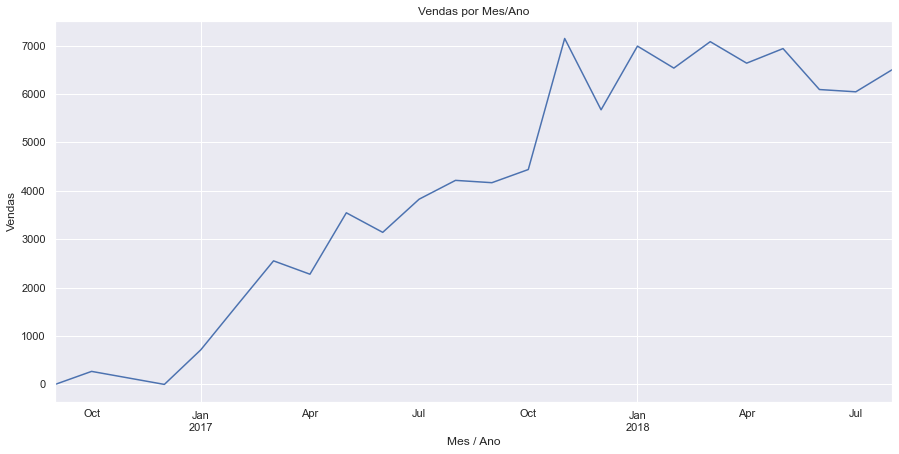

In [20]:
plt.figure(figsize = (15, 7))
dtOrdersMesAno.groupby('order_approved_at').count()['order_id'].plot(kind = 'line')

plt.xlabel('Mes / Ano')
plt.ylabel('Vendas')
plt.title('Vendas por Mes/Ano')

plt.show()

## 2.2.1 Existe diferença significativa de venda para cada um dos meses?

Conforme a analise abaixo é perceptivel que ao longo do ano de 2017, apesar de possuirem algumas oscilações, as vendas se mantiveram crescentes. Conforme se aproxima das datas festivas no mes de dezembro (12) as vendas tendem a crescer com maior intensidade. Porém, apesar da analise inicial, não é possível afirmar que os meses tem impacto em relação as vendas, para isso precisariamos de um historico maior de vendas ao longo de mais anos.

Além disso, seria necessário realizar testes estatisticos que nao serão realizadas devido a falta de necessidade na base atual.

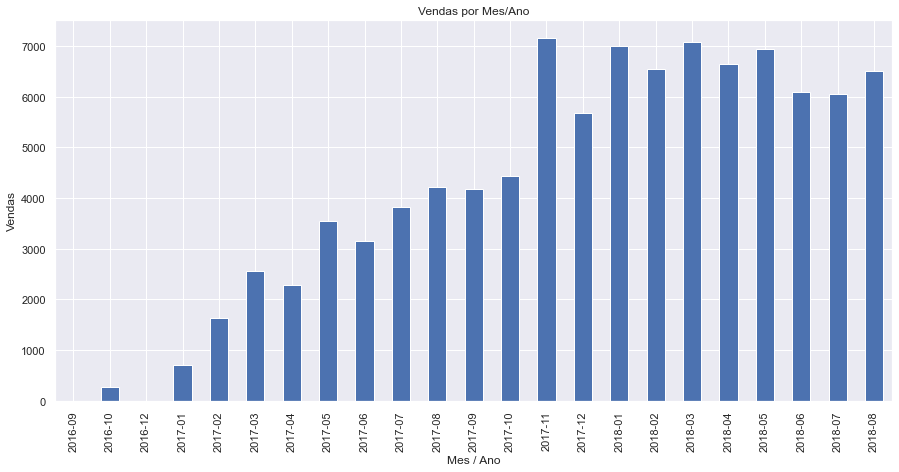

In [21]:
plt.figure(figsize = (15, 7))
dtOrdersMesAno.groupby('order_approved_at').count()['order_id'].plot(kind = 'bar')

plt.xlabel('Mes / Ano')
plt.ylabel('Vendas')
plt.title('Vendas por Mes/Ano')

plt.show()

## 2.2.2 Existe diferença significativa de venda para cada um dos dias da semana?

In [22]:
# Criando copia dataset ajustado
dtOrdersMesAnoDia = dtOrdersAjustado[['order_id', 'order_approved_at']].copy()

In [23]:
dtOrdersMesAnoDia['weekday'] = dtOrdersMesAnoDia['order_approved_at'].dt.dayofweek

In [24]:
dtOrdersMesAnoDia.head()

,order_id,order_approved_at,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,3
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,2
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,1


In [25]:
# Mantendo somente Ano, Mes e Dia
dtOrdersMesAnoDia['order_approved_at'] = pd.to_datetime(dtOrdersMesAnoDia['order_approved_at'],\
                                                        format = '%Y-%m-%d %H:%M:%S').dt.to_period('y')

In [26]:
dtOrdersMesAnoDia.head()

,order_id,order_approved_at,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,2017,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018,3
2,47770eb9100c2d0c44946d9cf07ec65d,2018,2
3,949d5b44dbf5de918fe9c16f97b45f8a,2017,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2018,1


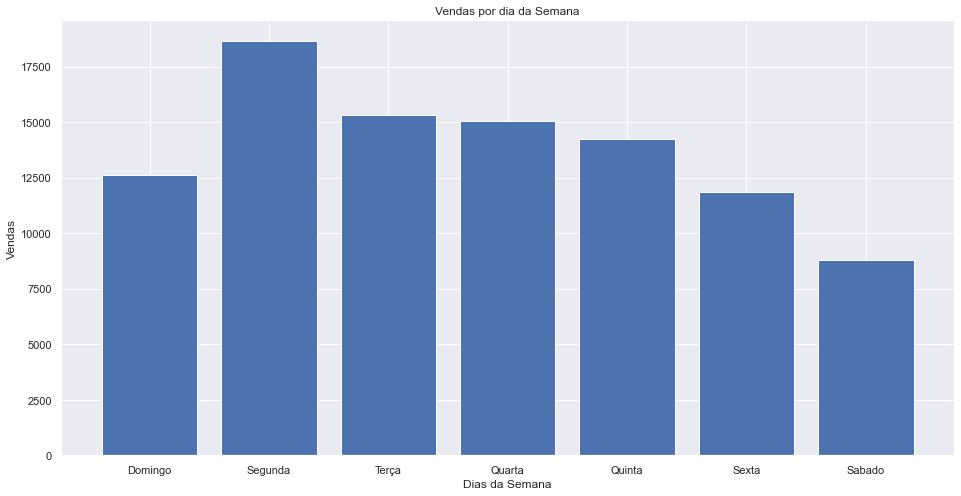

In [27]:
fig, ax = plt.subplots(figsize = (16, 8))

labels = ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado']

ax.bar(labels, dtOrdersMesAnoDia.groupby('weekday').count()['order_id'])

ax.set_xlabel('Dias da Semana')
ax.set_ylabel('Vendas')
ax.set_title('Vendas por dia da Semana')

plt.show()

In [28]:
dtOrdersMesAnoDia2016 = dtOrdersMesAnoDia[dtOrdersMesAnoDia['order_approved_at'] == '2016'].groupby('weekday').\
count()['order_id']
dtOrdersMesAnoDia2017 = dtOrdersMesAnoDia[dtOrdersMesAnoDia['order_approved_at'] == '2017'].groupby('weekday').\
count()['order_id']
dtOrdersMesAnoDia2018 = dtOrdersMesAnoDia[dtOrdersMesAnoDia['order_approved_at'] == '2018'].groupby('weekday').\
count()['order_id']

In [29]:
dtOrdersMesAnoDia.groupby(['order_approved_at', 'weekday']).count()

order_id
order_approved_at weekday          
2016              0              40
                  1              44
                  2              11
                  3              97
                  4              48
                  5              23
                  6               9
2017              0            5285
                  1            8096
                  2            6971
                  3            6399
                  4            6582
                  5            5709
                  6            4312
2018              0            7290
                  1           10504
                  2            8348
                  3            8549
                  4            7588
                  5            6104
                  6            4452

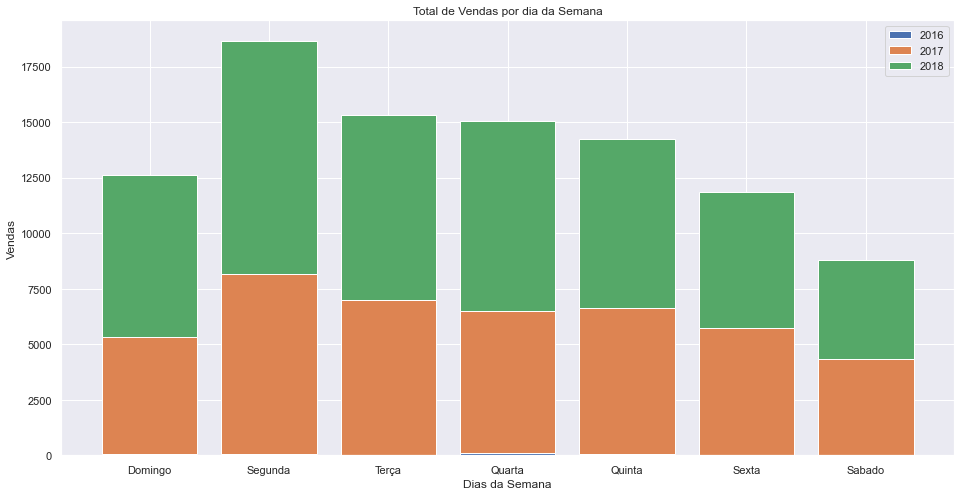

In [30]:
fig, ax = plt.subplots(figsize = (16, 8))

labels = ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado']

ax.bar(labels, dtOrdersMesAnoDia2016, label = '2016')
ax.bar(labels, dtOrdersMesAnoDia2017, label = '2017', bottom = dtOrdersMesAnoDia2016)
ax.bar(labels, dtOrdersMesAnoDia2018, label = '2018', bottom = dtOrdersMesAnoDia2016 + dtOrdersMesAnoDia2017)

ax.set_xlabel('Dias da Semana')
ax.set_ylabel('Vendas')
ax.set_title('Total de Vendas por dia da Semana')
ax.legend()

plt.show()

In [31]:
# Criando copia para novo dataset
dtOrdersDiaMesAno = dtOrdersAjustado[['order_id', 'order_approved_at']].copy()

# Mantendo somente Ano, Mes e Dia
dtOrdersDiaMesAno['Data'] = \
    pd.to_datetime(dtOrdersDiaMesAno['order_approved_at'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('d')

In [32]:
# Criandop coluna de Ano
dtOrdersDiaMesAno['Ano'] = \
    pd.to_datetime(dtOrdersDiaMesAno['order_approved_at'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('y')

In [33]:
# Criando coluna de weekday
dtOrdersDiaMesAno['weekday'] = dtOrdersDiaMesAno['order_approved_at'].dt.dayofweek

In [34]:
dtOrdersDiaMesAno.head()

,order_id,order_approved_at,Data,Ano,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10-02,2017,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,2018-07-26,2018,3
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,2018-08-08,2018,2
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,2017-11-18,2017,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,2018-02-13,2018,1


In [35]:
def cria_media_semanal_por_ano(data, ano):
    dtAnoDia = data[data['Ano'] == ano].groupby('weekday').nunique()
    dtAnoDia['Media_Vendas'] = dtAnoDia.apply(lambda x: int(x['order_id'] / x['Data']), axis = 1)
    dtAnoDia = dtAnoDia['Media_Vendas']
    
    return dtAnoDia

In [36]:
# Calcula media de vendas por dia da semana do ano de 2016
dtOrdersDiaMesAno2016 = cria_media_semanal_por_ano(dtOrdersDiaMesAno, '2016')

In [37]:
# Calcula media de vendas por dia da semana do ano de 2017
dtOrdersDiaMesAno2017 = cria_media_semanal_por_ano(dtOrdersDiaMesAno, '2017')

In [38]:
# Calcula media de vendas por dia da semana  do ano de 2018
dtOrdersDiaMesAno2018 = cria_media_semanal_por_ano(dtOrdersDiaMesAno, '2018')

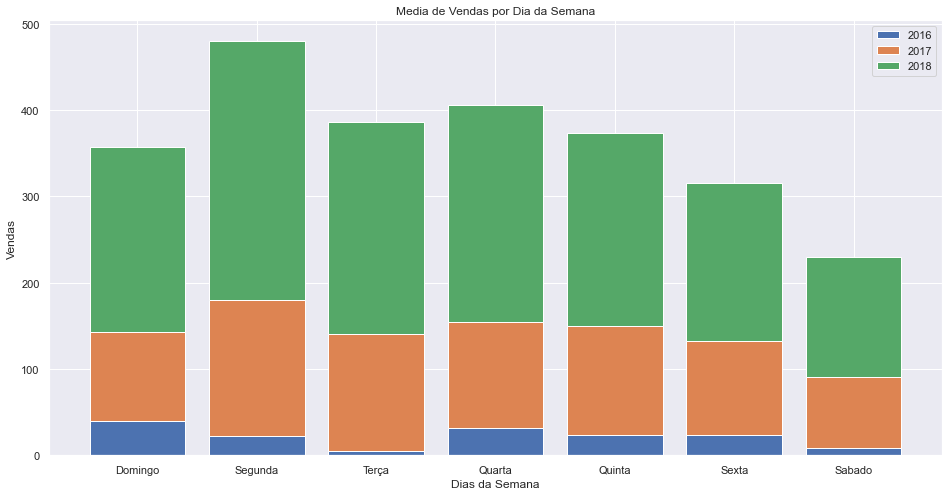

In [39]:
fig, ax = plt.subplots(figsize = (16, 8))

labels = ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado']

ax.bar(labels, dtOrdersDiaMesAno2016, label = '2016')
ax.bar(labels, dtOrdersDiaMesAno2017, label = '2017', bottom = dtOrdersDiaMesAno2016)
ax.bar(labels, dtOrdersDiaMesAno2018, label = '2018', bottom = dtOrdersDiaMesAno2016 + dtOrdersDiaMesAno2017)

ax.set_xlabel('Dias da Semana')
ax.set_ylabel('Vendas')
ax.set_title('Media de Vendas por Dia da Semana')
ax.legend()

plt.show()

## 2.2.3 Existe diferença significativa de venda para cada um dos metodos de pagamento?

In [40]:
dtOrderPayments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [41]:
dtOrderPayments.groupby('payment_type').count()

,order_id,payment_sequential,payment_installments,payment_value
payment_type,,,,
boleto,19784,19784,19784,19784
credit_card,76795,76795,76795,76795
debit_card,1529,1529,1529,1529
not_defined,3,3,3,3
voucher,5775,5775,5775,5775


In [42]:
dtOrderPayments = dtOrderPayments[dtOrderPayments['payment_type'] != 'not_defined']

In [43]:
dtOrderPayments.groupby('payment_type').count()

,order_id,payment_sequential,payment_installments,payment_value
payment_type,,,,
boleto,19784,19784,19784,19784
credit_card,76795,76795,76795,76795
debit_card,1529,1529,1529,1529
voucher,5775,5775,5775,5775


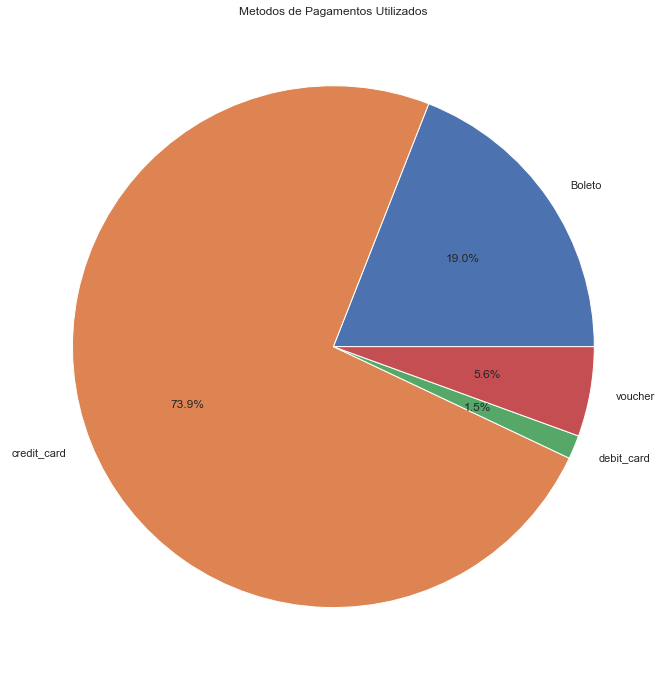

In [44]:
fig, ax = plt.subplots(figsize = (15, 12))

ax.pie(dtOrderPayments.groupby('payment_type').count()['order_id'],\
       labels = ['Boleto', 'credit_card', 'debit_card', 'voucher'], autopct = '%1.1f%%')

plt.title('Metodos de Pagamentos Utilizados')

plt.show()

## 2.2.4 Existe diferença significativa de venda por região?

In [46]:
dtCustomers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [49]:
salesState = dtCustomers.groupby('customer_state')['customer_id'].count()

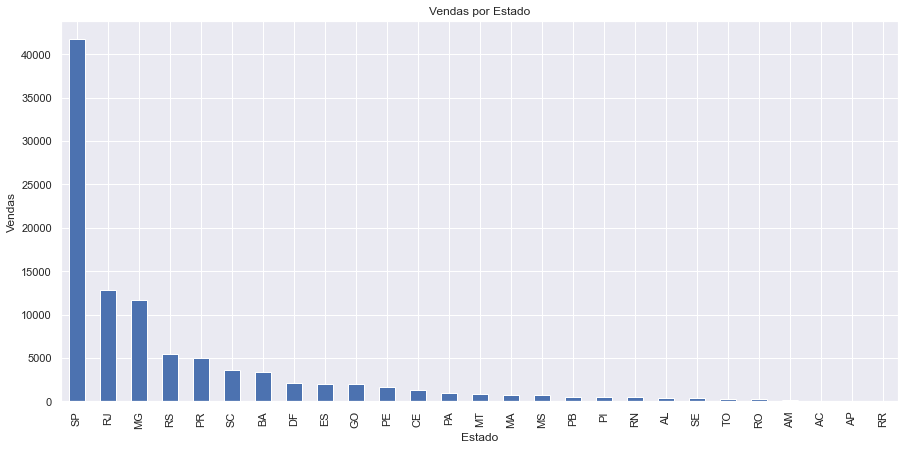

In [55]:
plt.figure(figsize = (15, 7))
salesState.sort_values(ascending = False).plot(kind = 'bar')

plt.xlabel('Estado')
plt.ylabel('Vendas')
plt.title('Vendas por Estado')

plt.show()

In [63]:
salesStatePercent = salesState.copy()
salesStatePercent = salesStatePercent.to_frame()

In [68]:
# Calculando porcentagem de cada estado em relação ao total de vendas
salesStatePercent['percent'] = (salesStatePercent['customer_id'] / salesStatePercent['customer_id'].sum()) * 100

Analisando abaixo é perceptivel que o estado de São Paulo possui o maior numero de vendas disparado, com 40% das vendas, seguido do Rio de Janeiro e Minas Gerais com aproximadamente 13% das vendas.

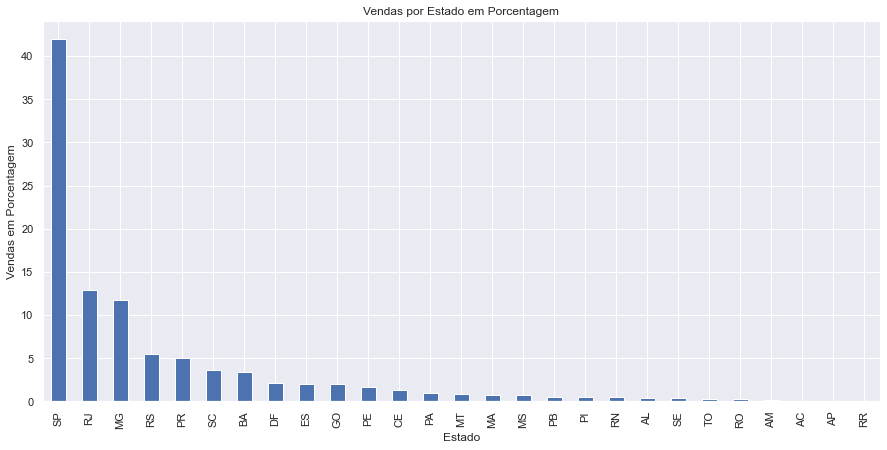

In [72]:
plt.figure(figsize = (15, 7))
salesStatePercent['percent'].sort_values(ascending = False).plot(kind = 'bar')

plt.xlabel('Estado')
plt.ylabel('Vendas em Porcentagem')
plt.title('Vendas por Estado em Porcentagem')

plt.show()

## 2.2.5 Existe diferença significativa de numero de clientes por região?

In [91]:
customerState = dtCustomers[['customer_unique_id', 'customer_state']].drop_duplicates().copy()

In [93]:
customerState = customerState.groupby('customer_state')['customer_unique_id'].count()

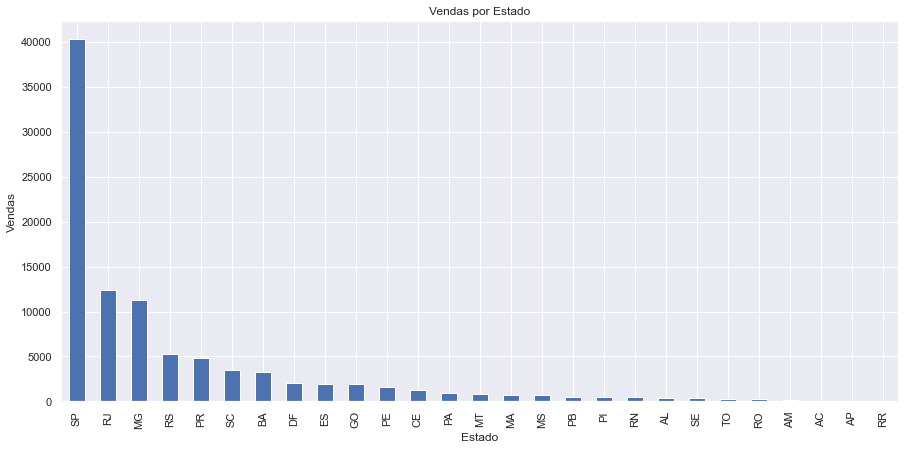

In [94]:
plt.figure(figsize = (15, 7))
customerState.sort_values(ascending = False).plot(kind = 'bar')

plt.xlabel('Estado')
plt.ylabel('Clientes')
plt.title('Clientes por Estado')

plt.show()

In [97]:
customerStatePercent = customerState.copy()
customerStatePercent = customerStatePercent.to_frame()

In [98]:
# Calculando porcentagem de cada estado em relação ao total de vendas
customerStatePercent['percent'] =\
        (customerStatePercent['customer_unique_id'] / customerStatePercent['customer_unique_id'].sum()) * 100

Analisando abaixo é perceptivel que o estado de São Paulo possui o maior numero de clientes disparado, com 40% dos clientes, seguido do Rio de Janeiro e Minas Gerais com aproximadamente 13% das vendas. Após isso é perceptivel que os outros estados passam a possuir no maximo 5% das vendas chegando a alguns possuirem menos de 1%.

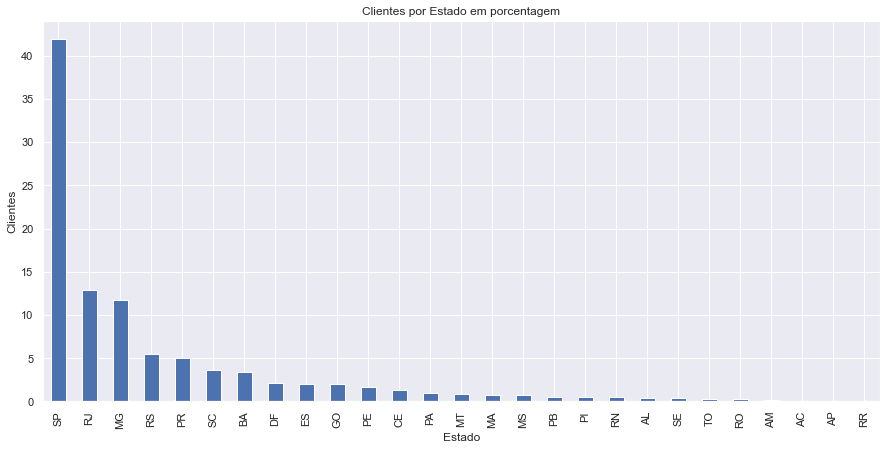

In [101]:
plt.figure(figsize = (15, 7))
customerStatePercent['percent'].sort_values(ascending = False).plot(kind = 'bar')

plt.xlabel('Estado')
plt.ylabel('Clientes')
plt.title('Clientes por Estado em porcentagem')

plt.show()

## 3. Quais produtos e vendas possuem maior numero de vendas?

Foi identificado que não é fornecido o nome do produto vendido, somente a categoria.

In [114]:
dtOrderItems.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [115]:
dtProducts.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [116]:
# Realizando o merge entre as duas tabelas
dtOrderProducts = pd.merge(dtOrderItems, dtProducts, on = 'product_id')

In [122]:
dtOrderProducts.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0


In [131]:
# Contando o numero de orders (não unicos) e relacionando a categoria
categoryProducts = dtOrderProducts.groupby('product_category_name')['order_id'].count().sort_values(ascending = False)

Analisando o grafico abaixo é perceptivel a disparidade entre as catogiras mais vendidas. Contudo algumas categorias com maiores numeros de vendas aparentam possuir relação entre as mesmas. Como por exemplo 'cama_mesa_banho' e 'beleza_saude'. Também 'moveis_decoracao' e 'utilidades_domesticas'.

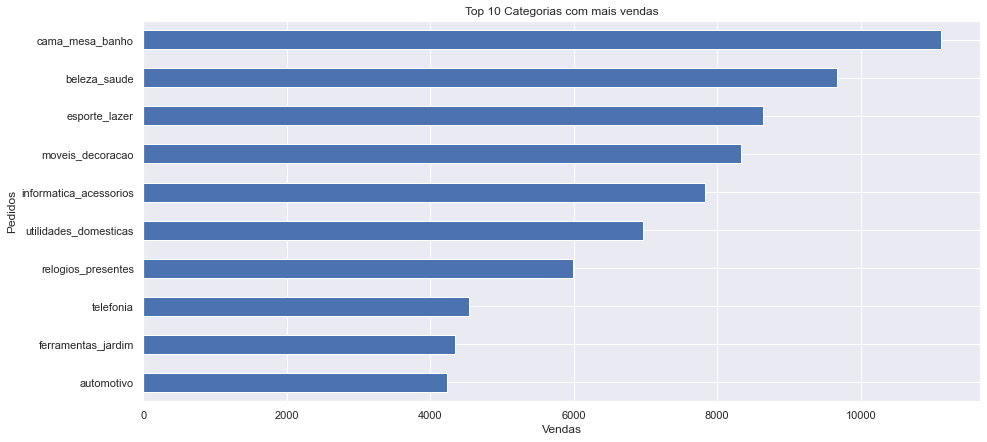

In [138]:
plt.figure(figsize = (15, 7))
categoryProducts.head(10).sort_values(ascending = True).plot(kind = 'barh')

plt.xlabel('Vendas')
plt.ylabel('Pedidos')
plt.title('Top 10 Categorias com mais vendas')

plt.show()

## 4. As notas de review do produto possuem impacto no número de vendas?

In [143]:
dtOrderItems.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [144]:
dtOrderReviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [145]:
reviewsOrders = pd.merge(dtOrderItems, dtOrderReviews, on = 'order_id')

In [147]:
reviewsOrders = reviewsOrders[['order_id', 'product_id', 'review_score']]

In [151]:
reviewsOrders = reviewsOrders.dropna()

In [152]:
reviewsOrders.head()

,order_id,product_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,5
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,4
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,4
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,5


In [168]:
pedidosProduto = reviewsOrders.groupby('product_id')['order_id'].count().sort_values(ascending = False)

In [171]:
pedidosProduto.head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    491
422879e10f46682990de24d770e7f83d    487
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    391
Name: order_id, dtype: int64

In [172]:
scoreProduto = reviewsOrders.groupby('product_id')['review_score'].mean().sort_values(ascending = False)

In [175]:
scoreProduto.head()

product_id
00066f42aeeb9f3007548bb9d3f33c38    5.0
86743ff92eee3d16b7df59cddd583b8c    5.0
868ceb027ab706a4dee42e2220006b85    5.0
868969d3a93aeeab7bfcd4fc3d3d65de    5.0
868766ed2172644fdd977d6bd395a107    5.0
Name: review_score, dtype: float64

In [178]:
scoreOrders = scoreProduto.copy()

In [180]:
scoreOrders = scoreOrders.to_frame()

In [181]:
scoreOrders = pd.merge(scoreProduto, pedidosProduto, on = 'product_id')

In [188]:
scoreOrders.head()

,score_medio,numero_pedidos
product_id,,
00066f42aeeb9f3007548bb9d3f33c38,5.0,1
86743ff92eee3d16b7df59cddd583b8c,5.0,1
868ceb027ab706a4dee42e2220006b85,5.0,1
868969d3a93aeeab7bfcd4fc3d3d65de,5.0,1
868766ed2172644fdd977d6bd395a107,5.0,1


In [186]:
scoreOrders.columns = ['score_medio', 'numero_pedidos']

In [189]:
scoreOrders.head()

,score_medio,numero_pedidos
product_id,,
00066f42aeeb9f3007548bb9d3f33c38,5.0,1
86743ff92eee3d16b7df59cddd583b8c,5.0,1
868ceb027ab706a4dee42e2220006b85,5.0,1
868969d3a93aeeab7bfcd4fc3d3d65de,5.0,1
868766ed2172644fdd977d6bd395a107,5.0,1


In [199]:
scoreOrders['score_medio'] = round(scoreOrders['score_medio'])

In [201]:
scoreOrders.sort_values(ascending = False, by = 'numero_pedidos').head()

,score_medio,numero_pedidos
product_id,,
aca2eb7d00ea1a7b8ebd4e68314663af,4.0,527
99a4788cb24856965c36a24e339b6058,4.0,491
422879e10f46682990de24d770e7f83d,4.0,487
389d119b48cf3043d311335e499d9c6b,4.0,392
368c6c730842d78016ad823897a372db,4.0,391


In [206]:
meanScoreOrders = scoreOrders.groupby('score_medio')['numero_pedidos'].sum()

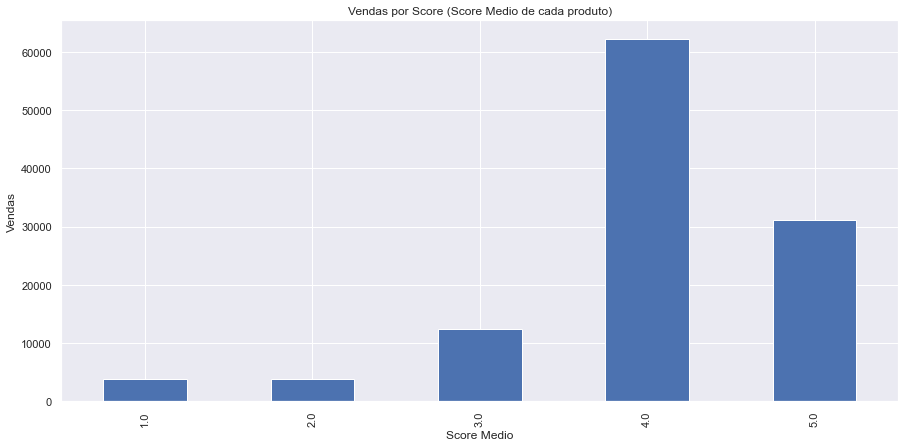

In [210]:
plt.figure(figsize = (15, 7))
meanScoreOrders.plot(kind = 'bar')

plt.xlabel('Score Medio')
plt.ylabel('Vendas')
plt.title('Vendas por Score (Score Medio de cada produto)')

plt.show()

## 4.1 WordCloud de Reviews

In [219]:
dtOrderReviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [220]:
dtOrderReviews = dtOrderReviews['review_comment_message']

In [222]:
dtOrderReviews = dtOrderReviews.dropna()

In [225]:
dtOrderReviews.head()

3                 Recebi bem antes do prazo estipulado.
4     Parabéns lojas lannister adorei comprar pela I...
9     aparelho eficiente. no site a marca do aparelh...
12      Mas um pouco ,travando...pelo valor ta Boa.\r\n
15    Vendedor confiável, produto ok e entrega antes...
Name: review_comment_message, dtype: object

In [245]:
def limpar_texto(text):
    # Convertendo para str
    text = str(text)
    
    # Remover caracteres non-ascii
    text = ''.join(caracter for caracter in text if ord(caracter) < 128)
    
    # Convertendo para lower case
    text = text.lower()
    
    # Removendo pontuação por expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    text = regex.sub(' ', str(text))
    
    # Carregando stopwords em Inglês
    portuguese_stops = set(stopwords.words('portuguese'))
    
    # Removendo stopwords em Inglês
    # Mantendo somente palavras que não são consideradas stopwords
    text = ' '.join(palavra for palavra in text.split() if palavra not in portuguese_stops)
    
    # Criando a estrutura baseada em uma wordnet para lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()    
    # Aplicando Lemmatization
    text = ' '.join(wordnet_lemmatizer.lemmatize(palavra) for palavra in text.split())
    
    return text

In [241]:
dtOrderReviews = dtOrderReviews.to_frame()

In [242]:
dtOrderReviewsTratado = dtOrderReviews.copy()

In [248]:
%%time
print('Tratanto texto...')
dtOrderReviewsTratado['review_comment_message'] = dtOrderReviews['review_comment_message'].map(limpar_texto)
print('Texto tratado')

Tratanto texto...
Texto tratado
Wall time: 11 s


In [249]:
dtOrderReviewsTratado.head()

,review_comment_message
3,recebi bem ante prazo estipulado
4,parabns lojas lannister adorei comprar interne...
9,aparelho eficiente site marca aparelho impress...
12,pouco travando valor ta boa
15,vendedor confivel produto ok entrega ante prazo


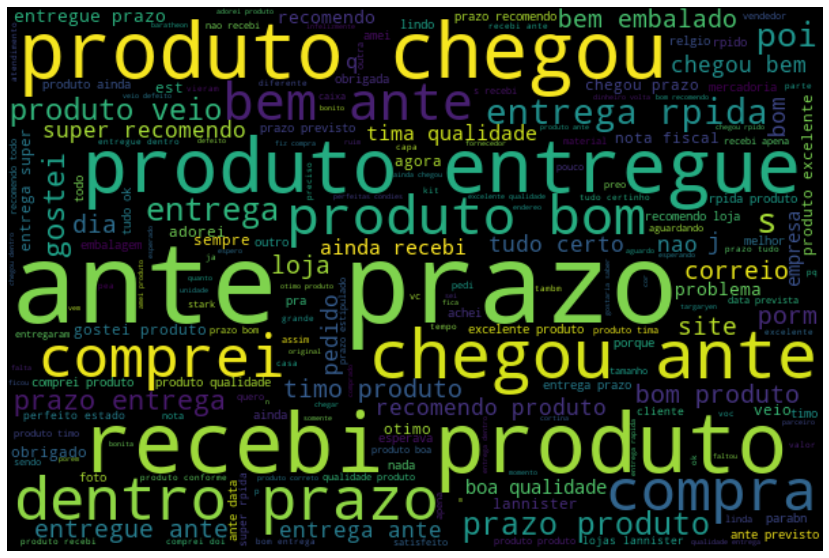

In [259]:
wordcloud = WordCloud(width = 600, height = 400).generate_from_text(\
                                                                ' '.join(dtOrderReviewsTratado['review_comment_message']))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 5. A localização impacta no tempo de entrega?

Por motivos de tempo para desenvolvimento, foi optado por realizar uma estimativa em mapa de calor de quantas vendas são realizas por micro região.

In [270]:
dtGeolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [271]:
latIng = dtGeolocation[['geolocation_lat', 'geolocation_lng']]

In [272]:
latIng.head()

,geolocation_lat,geolocation_lng
0,-23.545621,-46.639292
1,-23.546081,-46.644820
2,-23.546129,-46.642951
3,-23.544392,-46.639499
4,-23.541578,-46.641607


In [269]:
geolocator = Nominatim(user_agent = 'Brazilian E-commerce Olist')

In [278]:
mapa = folium.Map([48, 5], tiles = 'stamentoner', zoom_start = 6)

In [279]:
HeatMap(latIng).add_to(mapa)

In [280]:
mapa.save('mapa.html')

# O resto é história